# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
import matplotlib.cm as cm
from matplotlib.ticker import StrMethodFormatter
from scipy.linalg import eigh_tridiagonal
from scipy.fft import fft, fftfreq
from scipy.optimize import minimize
import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
def transform(N=None, f=None, default=True):                                        # Contains all the information of the orthogonal transformation
  if default:                                                                       # For an analytic homogeneous coupling
    Lambda = np.zeros((N, N))
    S = np.zeros((N, N))                                                            # Transformation matrix
    for i in range(N):
      norm_cst = np.sqrt(np.sum([(np.sin((i+1)*(k+1)*np.pi/(N+1)))**2
                                 for k in range(N)]))                               # Normalization factor
      for j in range(N):
        S[i,j] = np.sin((i+1)*(j+1)*np.pi/(N+1))/norm_cst
        Lambda[i,j] = 2*np.cos(np.pi*(i+1)/(N+1)) + 2*np.cos(np.pi*(j+1)/(N+1))     # Matrix with all possible sums of eigenvalues
    eigenvalues = np.array([2*np.cos(np.pi*(i+1)/(N+1)) for i in range(N)])         # List with eigenvalues
  else:                                                                             # For a custom coupling profile
    N = len(f) + 1
    Lambda = np.zeros((N, N))
    eigenvalues, S = eigh_tridiagonal(np.zeros(N), f, check_finite=False)           # Numerical eigenvalues and eigenvectors
    eigenvalues = eigenvalues[::-1]                                                 # Ordering eigenvalues from largest to smalesst
    S = S[:, ::-1]                                                                  # Ordering eigenvectors according to eigenvalues
    S = S.T
    for i in range(N):
      for j in range(N):
        Lambda[i,j] = eigenvalues[i] + eigenvalues[j]
  return S, Lambda, eigenvalues

def eta(N=None, profile_type='all', l=None, pump=None, default=True):               # Unit vector eta
  if default:
    if profile_type == 'all':
      return [1 for i in range(N)] / np.sqrt(N)                                     # Homogeneous injection
    elif profile_type == 'one':                                                     # Injection in the waveguide number "l"
      if l is None:
        l = int((N + 1)/2)                                                          # Injection in the center if waveguide number is not specified
      return [1 if l - 1 == i else 0 for i in range(N)]
  else:
      return [j for j in pump] / np.sqrt(np.sum(np.abs(pump) ** 2))

def i2s(X_i, transf_data):                                                          # transforms from individual-mode basis to supermode basis
  S = transf_data[0]
  if isinstance(X_i, tuple):
    return tuple(S @ x_i @ S.transpose() for x_i in X_i)
  elif isinstance(X_i, np.ndarray):
    return S @ X_i @ S.transpose()

def s2i(X_s, transf_data):                                                          # transforms from supermode basis to individual-mode basis
  S = transf_data[0]
  if isinstance(X_s, tuple):
    return tuple(S.transpose() @ x_s @ S for x_s in X_s)
  elif isinstance(X_s, np.ndarray):
    return S.transpose() @ X_s @ S

def JSA(Q):                                                                         # calculates joint-spatial amplitude
  N = Q.shape[-1]
  return 2 ** (1 - np.eye(N) / 2) * Q

def Q_s(z, C0, g, alpha, pump_data, transf_data, add_matrices=False):               # solution in the supermode basis
  S, Lambda, eigenvalues = transf_data
  N = len(eigenvalues)

  P = np.diag(pump_data)
  P_s = i2s(P, transf_data)                                                         # Pump matrix in supermode basis
  T_s = np.exp(1j * C0 * Lambda * z / 2) * np.sinc(C0 * Lambda * z / (2 * np.pi))   # Phase matching matrix in supermode basis
  Q_s = 1j * z * g * alpha * P_s * T_s
  if add_matrices:
    return Q_s, T_s, P_s
  else:
    return Q_s

def corr(X):
  N = X.shape[-1]                                                                     # Correlation matrix
  norm =  np.sum(2 ** (np.eye(N) - 1) * np.abs(X) ** 2, axis=(-1, -2), keepdims=True) # Norm of state
  return np.abs(X) ** 2 / norm

def n(X):
  N = X.shape[-1]                                                                     # Normalized expectation value of number operator
  n = np.sum((1 + np.eye(N)) * np.abs(X) ** 2, axis=-1)
  n_norm = n / np.sum(n, axis=-1, keepdims=True)
  return np.where(np.isnan(n_norm), 0, n_norm)

def st_dev(dist):                                                                     # Standard deviation
  if len(dist.shape) == 2:
    points, N = dist.shape
    M = np.tile(np.linspace(1, N, N), (points, 1))                                    # Waveguide numbers
  else:
    N = len(dist)
    M = np.linspace(1, N, N)
  return np.sqrt(np.sum(M ** 2 * dist, axis=-1) - np.sum(M * dist, axis=-1) ** 2)

def simulate(N, C0, g, alpha, L, pump_data, transf_data, basis='individual', calc_std=False, points=200, add_matrices=False):
  z = np.linspace(0, L, points)[:, None, None] * np.ones((N, N))
  sol = Q_s(z, C0, g, alpha, pump_data, transf_data, add_matrices)
  if basis == 'individual':
    sol = s2i(sol, transf_data)
  if add_matrices:
    Q = sol[0]
  else:
    Q = sol
  K = JSA(Q)
  prob = n(K)
  corr_map = corr(K)

  if calc_std and basis:
    std = st_dev(prob)                                                              # Standard deviation
    #std[0] = 1e-10
    _ = z[:, 0, 0]
    #_[0] = 1e-10
    std_der = np.gradient(np.log(std), np.log(C0 * _), edge_order=2)         # Logarithmic derivative of standard deviaton
    return prob, corr_map, std, std_der
  elif add_matrices:                                                                # Returns matrix decomposition of Hadamard product
    return prob, corr_map, K, *sol[1:]
  else:
    return prob, corr_map

def linear(N, C0, L, input_data, transf_data, basis='individual', calc_std=False, points=200):
  z = np.linspace(0, L, points)[:, None] * np.ones(N)
  _, _, eigenvalues = transf_data
  U_s = np.where(np.broadcast_to(np.eye(N), (points, N, N)), np.exp(1j * C0 * eigenvalues * z)[:, None], 0)
  U_i = s2i(U_s, transf_data)

  Q_i = U_i @ input_data
  K_i = JSA(Q_i)
  return K_i

def create_target(N, indexes, vanishing=False):                                     # Creates target correlation matrix for optimization
  all_idx = [(i, j) for i in range(N) for j in range(N)]
  nonzero_idx = indexes
  zero_idx = [i for i in indexes if i not in nonzero_coeffs]
  if vanishing:
    nonzero_idx, zero_idx = zero_idx, nonzero_idx

  target = np.zeros((N, N))
  for pair in nonzero_idx:
    target[pair] = 1
  _ = np.sum(2 ** (np.eye(N) - 1) * target)

  return target / _

def merit(var, target, transf_data, N, basis='individual'):                         # Merit function for optimization
  N = int((len(var) - 1) / 2 )
  z = var[0]
  pump = var[1:]
  pump_data = eta(pump=[abs(pump[2 * i]) * np.exp(1j * pump[2 * i + 1]) for i in range(N)], default=False)
  Q = Q_s(z, C0=1, g=1, alpha=1, pump_data=pump_data, transf_data=transf_data)
  if basis == 'individual':
    Q = s2i(Q, transf_data)
  K = JSA(Q)
  corr_m = corr(K)

  merit = np.sum((corr_m - target) ** 2)
  return merit

def similarity(target, optimization):
  return np.sum(np.sqrt(target * optimization)) ** 2 / (np.sum(target) * np.sum(optimization))

# Main

## Center waveguide injection

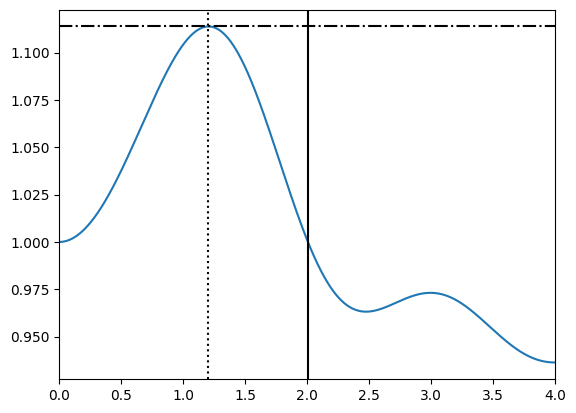

Superballistic propagation ends at z = 2.005
Max n is reached at z = 1.203 for a value of n = 1.114


In [17]:
# User-defined parameters
N = 41                       # dimension of array, number of waveguides
C0 = 1                        # linear coupling constant
L = 4 / C0                   # propagation distance
g = 1                         # nonlinear constant
alpha = 1                     # magnitud of pump field vector
points = 2000                  # number of points to simulate
z = np.linspace(0, L, points)
transf_data = transform(N, default=True)
pump_data = eta(N, profile_type='one', default=True)

*_, std_der = simulate(N, C0, g, alpha, L, pump_data, transf_data, basis='individual', calc_std=True, points=points)
idx_ref = points // 10
idx_trans = idx_ref + np.argmin(np.abs(std_der[idx_ref:] - 1))
z_trans = z[idx_trans]
idx_max = np.nanargmax(std_der)
z_max = z[idx_max]
n_max = std_der[idx_max]

plt.plot(z, std_der)
plt.axvline(z_max, c='k', ls=':')
plt.axhline(n_max, c='k', ls='-.')
plt.axvline(z_trans, c='k', ls='-')
plt.xlim(z[0], z[-1])
plt.show()

print(f'Superballistic propagation ends at z = {z_trans:.3f}')
print(f'Max n is reached at z = {z_max:.3f} for a value of n = {n_max:.3f}')

## Corner waveguide injection

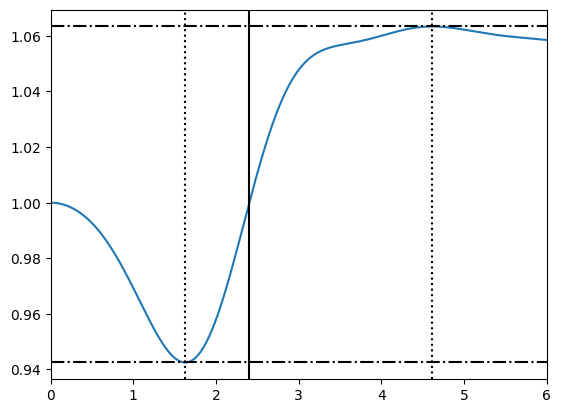

Superballistic propagation ends at z = 2.404
Min n is reached at z = 1.630 for a value of n = 0.943
Max n is reached at z = 4.619 for a value of n = 1.063


In [16]:
# User-defined parameters
N = 41                       # dimension of array, number of waveguides
C0 = 1                        # linear coupling constant
L = 6 / C0                   # propagation distance
g = 1                         # nonlinear constant
alpha = 1                     # magnitud of pump field vector
points = 2000                  # number of points to simulate
z = np.linspace(0, L, points)
transf_data = transform(N, default=True)
pump_data = eta(N, profile_type='one', l=1, default=True)

*_, std_der = simulate(N, C0, g, alpha, L, pump_data, transf_data, basis='individual', calc_std=True, points=points)
idx_ref = points // 10
idx_trans = idx_ref + np.argmin(np.abs(std_der[idx_ref:] - 1))
z_trans = z[idx_trans]
idx_max = np.nanargmax(std_der)
z_max = z[idx_max]
n_max = std_der[idx_max]
idx_min = np.nanargmin(std_der)
z_min = z[idx_min]
n_min = std_der[idx_min]

plt.plot(z, std_der)
plt.axvline(z_max, c='k', ls=':')
plt.axhline(n_max, c='k', ls='-.')
plt.axvline(z_min, c='k', ls=':')
plt.axhline(n_min, c='k', ls='-.')
plt.axvline(z_trans, c='k', ls='-')
plt.xlim(z[0], z[-1])
plt.show()

print(f'Superballistic propagation ends at z = {z_trans:.3f}')
print(f'Min n is reached at z = {z_min:.3f} for a value of n = {n_min:.3f}')
print(f'Max n is reached at z = {z_max:.3f} for a value of n = {n_max:.3f}')

## Comparison of propagations

In [18]:
# User-defined parameters
C0 = 1                        # linear coupling constant
g = 1                         # nonlinear constant
alpha = 1                     # magnitud of pump field vector
points = 400                  # number of points to simulate

N_list = [71, 201, 71, 71, 201, 71]
L_list = [20 / C0, 20 / C0, 4 / C0, 40 / C0, 40 / C0, 4.8 / C0]
l_list = [None, None, None, 1, 1, 1]
der_list = []
prob_list = []
std_list = []
for N, L, l in zip(N_list, L_list, l_list):
  transf_data = transform(N, default=True)
  pump_data = eta(N, profile_type='one', l=l, default=True)
  prob, corr_m, std, std_der = simulate(N, C0, g, alpha, L, pump_data, transf_data, basis='individual', calc_std=True, points=points)
  der_list.append(std_der)
  prob_list.append(prob)
  std_list.append(std)

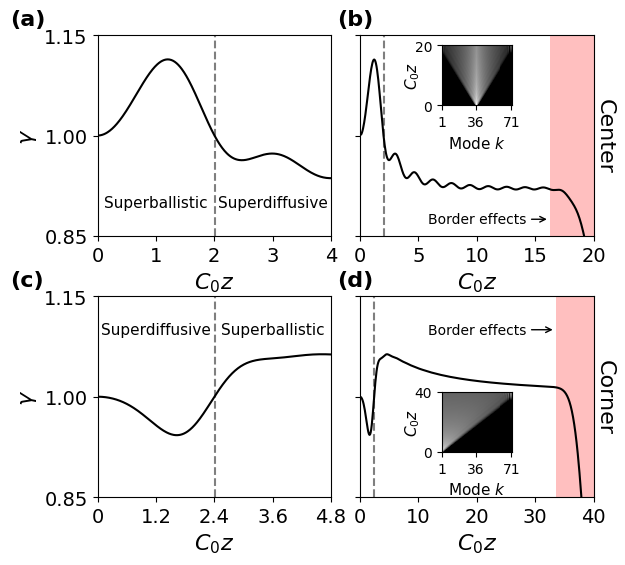

In [19]:
font_size = 16
text_size = 11
tick_size = 14

z_long_center = np.linspace(0, 20 / C0, points)
z_short_center = np.linspace(0, 4 / C0, points)
z_trans_l_center = z_long_center[np.where(np.abs(der_list[0] - 1) < 1e-3)[0][-1]]
z_trans_s_center = z_short_center[np.where(np.abs(der_list[2] - 1) < 1e-3)[0][-1]]
z_border_center = z_long_center[np.where(np.abs(der_list[0] - der_list[1]) > 5e-4)[0][0]]

z_long_corner = np.linspace(0, 40 / C0, points)
z_short_corner = np.linspace(0, 4.8 / C0, points)
z_trans_l_corner = z_long_corner[np.where(np.abs(der_list[3] - 1) < 1e-3)[0][0]]
z_trans_s_corner = z_short_corner[np.where(np.abs(der_list[5] - 1) < 1e-3)[0][-1]]
z_border_corner = z_long_corner[np.where(np.abs(der_list[3] - der_list[4]) > 5e-4)[0][0]]

fig, axs = plt.subplots(2, 2, figsize=(6.4, 6), sharey=True)
axs[0, 0], axs[0, 1] = axs[0, 1], axs[0, 0]
axs[1, 0], axs[1, 1] = axs[1, 1], axs[1, 0]
axs[0, 0].plot(C0 * z_long_center, der_list[0], 'k')
axs[0, 1].plot(C0 * z_short_center, der_list[2], 'k')
axs[1, 0].plot(C0 * z_long_corner, der_list[3], 'k')
axs[1, 1].plot(C0 * z_short_corner, der_list[5], 'k')

rect0 = patches.Rectangle((0, 0.85), C0 * z_trans_l_center, 0.3, fc='black', alpha=0.25)
rect1 = patches.Rectangle((C0 * z_border_center, 0.85), C0 * (z_long_center[-1] - z_border_center), 0.3, fc='red', alpha=0.25)
rect2 = patches.Rectangle((0, 0.85), C0 * z_trans_s_center, 0.3, fc='black', alpha=0.25)

rect3 = patches.Rectangle((0, 0.85), C0 * z_trans_l_corner, 0.3, fc='black', alpha=0.25)
rect4 = patches.Rectangle((C0 * z_border_corner, 0.85), C0 * (z_long_corner[-1] - z_border_corner), 0.3, fc='red', alpha=0.25)
rect5 = patches.Rectangle((0, 0.85), C0 * z_trans_s_corner, 0.3, fc='black', alpha=0.25)

#axs[0, 0].add_patch(rect0)
axs[0, 0].add_patch(rect1)
#axs[0, 1].add_patch(rect2)
#axs[1, 0].add_patch(rect3)
axs[1, 0].add_patch(rect4)
#axs[1, 1].add_patch(rect5)

axs[0, 0].axvline(z_trans_l_center * C0, color='black', linestyle='--', alpha=0.5)
axs[0, 1].axvline(z_trans_s_center * C0, color='black', linestyle='--', alpha=0.5)
axs[1, 0].axvline(z_trans_l_corner * C0, color='black', linestyle='--', alpha=0.5)
axs[1, 1].axvline(z_trans_s_corner * C0, color='black', linestyle='--', alpha=0.5)

# Limits and ticks
axs[0, 0].set_xlim(0, 20)
axs[0, 1].set_xlim(0, 4)
axs[1, 0].set_xlim(0, 40)
axs[1, 1].set_xlim(0, 4.8)
axs[1, 1].set_xticks([0, 1.2, 2.4, 3.6, 4.8], [0, 1.2, 2.4, 3.6, 4.8])

#ax.text(C0 * z_border + C0 * (z_long[-1] - z_border) / 2, 1, 'Border effects', fontsize=font_size - 2, rotation=-90, verticalalignment='center', horizontalalignment='center')
#ax2.text(C0 * z_border2 + C0 * (z_long2[-1] - z_border2) / 2, 1, 'Border effects', fontsize=font_size - 2, rotation=-90, verticalalignment='center', horizontalalignment='center')
axs[0, 1].text(C0 * z_trans_s_center / 2, 0.9, 'Superballistic', fontsize=text_size, va='center', ha='center')
axs[0, 1].text(3 * C0 * z_trans_s_center / 2, 0.9, 'Superdiffusive', fontsize=text_size, va='center', ha='center')
axs[1, 1].text(C0 * z_trans_s_corner / 2, 1.1, 'Superdiffusive', fontsize=text_size, va='center', ha='center')
axs[1, 1].text(C0 * z_trans_s_corner + C0 * (z_short_corner[-1] - z_trans_s_corner) / 2, 1.1, 'Superballistic', fontsize=text_size, va='center', ha='center')
axs[0, 0].annotate('Border effects', (C0 * z_border_center, 0.875), (10, 0.875), arrowprops=dict(arrowstyle='->', color='black'), ha='center', va='center', fontsize=text_size - 1)
axs[1, 0].annotate('Border effects', (C0 * z_border_corner, 1.1), (20, 1.1), arrowprops=dict(arrowstyle='->', color='black'), ha='center', va='center', fontsize=text_size - 1)

# Insets
axinset1 = axs[0, 0].inset_axes([0.35, 0.65, 0.3, 0.3])
pc1 = axinset1.pcolor(prob_list[0], norm=colors.LogNorm(vmin=1e-3, vmax=1), cmap='binary_r')
#fig.colorbar(pc1)
axinset2 = axs[1, 0].inset_axes([0.35, 0.225, 0.3, 0.3])
axinset2.pcolor(prob_list[3], norm=colors.LogNorm(vmin=1e-3, vmax=1), cmap='binary_r')
axs_inset = [axinset1, axinset2]
axinset1.set_yticks([1, points], [0, 20])
axinset2.set_yticks([1, points], [0, 40])
for axis in axs_inset:
  #axis.set_xticks([0, N // 2, N], [- (N // 2), 0, N // 2])
  axis.set_xticks([0.5, N // 2 - 0.5, N - 0.5], [1, N // 2 + 1, N])
  axis.set_xlabel('Mode $k$', fontsize=text_size)
  axis.set_ylabel('$C_0z$', labelpad=-5, fontsize=text_size)

for j, ax in enumerate(axs.flatten()):
  ax.set_ylim(0.85, 1.15)
  ax.tick_params(axis='both', labelsize=tick_size)
  ax.set_xlabel('$C_0z$', fontsize=font_size)
  if j % 2 != 0:
    ax.set_ylabel('$\gamma$', fontsize=font_size)
    ax.set_yticks([0.85, 1, 1.15], [0.85, 1.00, 1.15])
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.2f}'))

axs[0, 0].text(1.05, 0.5, 'Center', rotation=-90, ha='center', va='center', transform=axs[0, 0].transAxes, fontsize=font_size)
axs[1, 0].text(1.05, 0.5, 'Corner', rotation=-90, ha='center', va='center', transform=axs[1, 0].transAxes, fontsize=font_size)

letters = ['(b)', '(a)', '(d)', '(c)']
for j, (letter, ax) in enumerate(zip(letters, axs.flatten())):
  if j % 2:
    ax.text(-0.375, 1.05, letter, transform=ax.transAxes, size=font_size, weight='bold')
  else:
    ax.text(-0.1, 1.05, letter, transform=ax.transAxes, size=font_size, weight='bold')

fig.subplots_adjust(hspace=0.3)
fig.subplots_adjust(wspace=0.125)
plt.show()

# SM

## Border effects for center waveguide injection

In [47]:
C0 = 1                        # linear coupling constant
g = 1                         # nonlinear constant
alpha = 1                     # magnitud of pump field vector
points = 100                  # number of points to simulate

N_list = [25, 50, 75, 100, 500, 1000]
L_list = [20 / C0] * int(len(N_list) / 2) + [200 / C0] * int(len(N_list) / 2)
der_list = []
prob_list = []
std_list = []
for N, L in zip(N_list, L_list):
  transf_data = transform(N, default=True)
  pump_data = eta(N, profile_type='one', default=True)
  prob, corr_m, std, std_der = simulate(N, C0, g, alpha, L, pump_data, transf_data, basis='individual', calc_std=True, points=points)
  der_list.append(std_der)
  prob_list.append(prob)
  std_list.append(std)

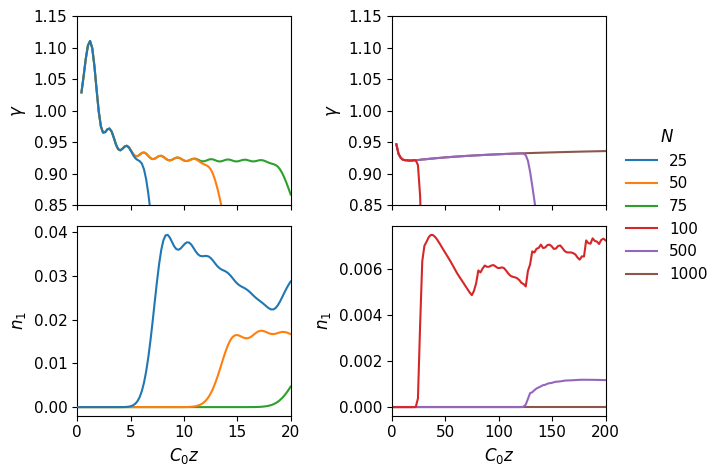

Steady value of gamma is 0.9361026191603514


In [48]:
fig, ax = plt.subplots(2, 2)

z1 = np.linspace(0, 20, points)
z2 = np.linspace(0, 200, points)

for j in range(int(len(N_list) / 2)):
  k = j + int(len(N_list) / 2)
  ax[0, 0].plot(C0 * z1, der_list[j], f'C{j}', zorder=int(len(N_list) / 2) - j)
  ax[0, 1].plot(C0 * z2, der_list[k], f'C{k}', zorder=int(len(N_list) / 2) - k)

for j in range(int(len(N_list) / 2)):
  k = j + int(len(N_list) / 2)
  ax[1, 0].plot(C0 * z1, prob_list[j][:, 0], f'C{j}', zorder=int(len(N_list) / 2) - j)
  ax[1, 1].plot(C0 * z2, prob_list[k][:, 0], f'C{k}', zorder=int(len(N_list) / 2) - k)

for j, axis in enumerate(ax.flatten()):
  axis.tick_params(axis='both', labelsize=11)
  if j < 2:
    axis.set_ylim(0.85, 1.15)
    axis.set_ylabel('$\\gamma$', fontsize=12)
  else:
    axis.set_ylabel('$n_1$', fontsize=12)
    axis.set_xlabel('$C_0z$', fontsize=12)

labels = [[0, 5, 10, 15, 20], [0, 50, 100, 150, 200]]

for j, label in enumerate(labels):
    ax[0, j].set_xticks(label, [''] * int(len(label)))
    ax[1, j].set_xticks(label, label)
    ax[j, 0].set_xlim(0, 20)
    ax[j, 1].set_xlim(0, 200)

fig.legend(N_list, title='$N$', fontsize=11, title_fontsize=12, bbox_to_anchor=(1.05, 0.575), loc='center', frameon=False)
#fig.subplots_adjust(hspace=0.1)
#fig.subplots_adjust(wspace=0.4)
plt.tight_layout()
plt.show()

print('Steady value of gamma is', der_list[-1][-1])

## Border effects for corner waveguide injection

In [40]:
C0 = 1                        # linear coupling constant
g = 1                         # nonlinear constant
alpha = 1                     # magnitud of pump field vector
points = 100                  # number of points to simulate

N_list = [25, 50, 75, 100, 500, 1000]
L_list = [40 / C0] * int(len(N_list) / 2) + [400 / C0] * int(len(N_list) / 2)
der_list = []
prob_list = []
std_list = []
for N, L in zip(N_list, L_list):
  transf_data = transform(N, default=True)
  pump_data = eta(N, profile_type='one', l=1, default=True)
  prob, corr_m, std, std_der = simulate(N, C0, g, alpha, L, pump_data, transf_data, basis='individual', calc_std=True, points=points)
  der_list.append(std_der)
  prob_list.append(prob)
  std_list.append(std)

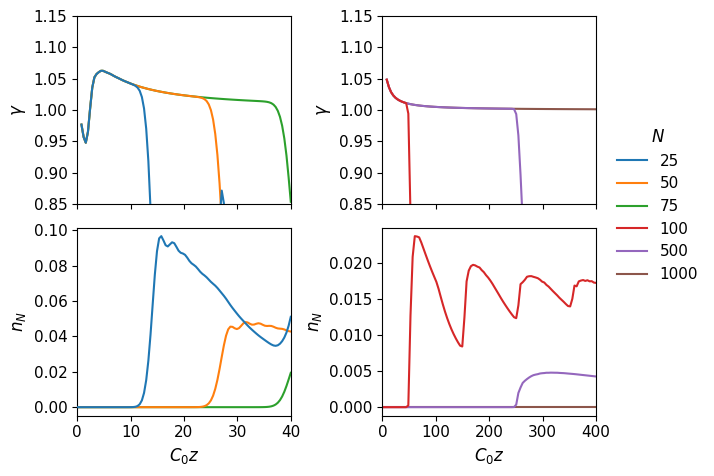

Steady value of gamma is 1.0012693026379793


In [46]:
fig, ax = plt.subplots(2, 2)

z1 = np.linspace(0, L_list[0], points)
z2 = np.linspace(0, L_list[-1], points)

for j in range(int(len(N_list) / 2)):
  k = j + int(len(N_list) / 2)
  ax[0, 0].plot(C0 * z1, der_list[j], f'C{j}', zorder=int(len(N_list) / 2) - j)
  ax[0, 1].plot(C0 * z2, der_list[k], f'C{k}', zorder=int(len(N_list) / 2) - k)

for j in range(int(len(N_list) / 2)):
  k = j + int(len(N_list) / 2)
  ax[1, 0].plot(C0 * z1, prob_list[j][:, -1], f'C{j}', zorder=int(len(N_list) / 2) - j)
  ax[1, 1].plot(C0 * z2, prob_list[k][:, -1], f'C{k}', zorder=int(len(N_list) / 2) - k)

for j, axis in enumerate(ax.flatten()):
  axis.tick_params(axis='both', labelsize=11)
  if j < 2:
    axis.set_ylim(0.85, 1.15)
    axis.set_ylabel('$\\gamma$', fontsize=12)
  else:
    axis.set_ylabel('$n_N$', fontsize=12)
    axis.set_xlabel('$C_0z$', fontsize=12)

labels = [[0, 10, 20, 30, 40], [0, 100, 200, 300, 400]]

for j, label in enumerate(labels):
  ax[0, j].set_xticks(label, [''] * int(len(label)))
  ax[1, j].set_xticks(label, label)
  ax[j, 0].set_xlim(0, L_list[0])
  ax[j, 1].set_xlim(0, L_list[-1])

#ax[0, 0].legend(N_list[:int(len(N_list) / 2)], title='$N$', fontsize=11, title_fontsize=12)
#ax[0, 1].legend(N_list[int(len(N_list) / 2):], title='$N$', fontsize=11, title_fontsize=12)

fig.legend(N_list, title='$N$', fontsize=11, title_fontsize=12, bbox_to_anchor=(1.05, 0.575), loc='center', frameon=False)
#fig.subplots_adjust(hspace=0.1)
#fig.subplots_adjust(wspace=0.4)
plt.tight_layout()
plt.show()

print('Steady value of gamma is', der_list[-1][-1])

## Border effects as a function of pumped waveguide

In [49]:
# User-defined parameters
C0 = 1                        # linear coupling constant
g = 1                         # nonlinear constant
alpha = 1                     # magnitud of pump field vector
points = 200                  # number of points to simulate

N = 151
L = 100 / C0
der_list = []
prob_list = []
std_list = []
for l in range(int((N + 1) / 2)):
  transf_data = transform(N, default=True)
  pump_data = eta(N, profile_type='one', l=l + 1, default=True)
  prob, corr_m, std, std_der = simulate(N, C0, g, alpha, L, pump_data, transf_data, basis='individual', calc_std=True, points=points)
  der_list.append(std_der)
  prob_list.append(prob)
  std_list.append(std)

der_list = np.array(der_list)

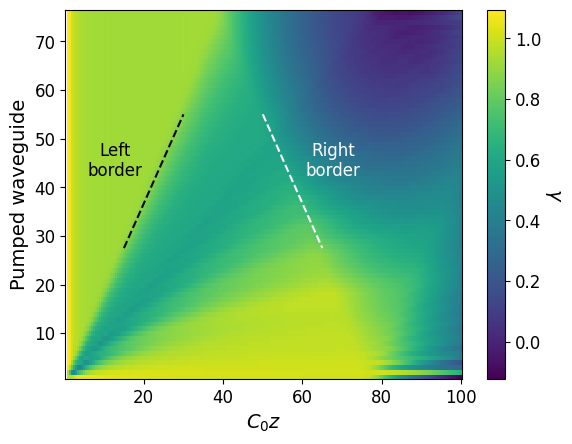

In [57]:
l_list = [l + 1 for l in range(int((N + 1) / 2))]
z = np.linspace(0, L, points)
pc = plt.pcolor(C0 * z[1:], l_list, der_list[:, 1:])
cbar = plt.colorbar(pc)

plt.xlabel('$C_0z$', fontsize=14)
plt.ylabel('Pumped waveguide', fontsize=14)
cbar.set_label(r'$\gamma$', fontsize=14, rotation=-90, labelpad=15)

plt.tick_params(axis='both', labelsize=12)
cbar.ax.tick_params(axis='y', labelsize=12)

plt.plot([15, 30], [27.5, 55], 'k--')
plt.plot([50, 65], [55, 27.5], 'w--')
#plt.axvline(40)

plt.text(0.125, 0.55, 'Left\nborder', transform=plt.gca().transAxes, fontsize=12, ha='center')
plt.text(0.675, 0.55, 'Right\nborder', transform=plt.gca().transAxes, fontsize=12, ha='center', c='white')
plt.savefig('Figure_3S.pdf', dpi=300, bbox_inches = "tight")
plt.show()